<a href="https://colab.research.google.com/github/erickgnfi-dotcom/ETL-restcountries-API/blob/main/ETL_restcountries_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
ETL Pipeline - Rest Country
Arquitectura Medallion: Bronze → Silver → Gold
"""

import requests
import pandas as pd
import json
from datetime import datetime
from typing import Dict, List
import time
import matplotlib.pyplot as plt
import seaborn as sns



In [19]:


# ============================================
# Extracción de datos raw
# ============================================

def extract_data(url, api_key=''):

  """Extrae datos crudos de la API y los almacena sin transformar"""

  print(f"Extrayendo datos de {url}")

  try:
    response = requests.get(f'{url}+{api_key}')
    print(f"✅ Extracción completada")
    return response.json()

  except requests.exceptions.RequestException as e:
    print(f"❌ Error en extracción: {e}")
    return {}



In [48]:
url = 'https://restcountries.com/v3.1/all?fields=name,currencies,population,region,area,continents,languages'
response = extract_data(url = url)

Extrayendo datos de https://restcountries.com/v3.1/all?fields=name,currencies,population,region,area,continents,languages
✅ Extracción completada


In [49]:


# ============================================
# CAPA BRONZE - Guarda datos sin transformar
# ============================================

def save_bronze(filename: str = 'rest_country_bronze.json'):
  """Guarda datos bronze en formato JSON"""

  with open(filename, 'w') as f:
    json.dump(response, f, indent=2)
    print(f"💾 BRONZE: Datos guardados en {filename}")



In [50]:
save_bronze()

💾 BRONZE: Datos guardados en rest_country_bronze.json


In [51]:
response

[{'name': {'common': 'Nepal',
   'official': 'Federal Democratic Republic of Nepal',
   'nativeName': {'nep': {'official': 'नेपाल संघीय लोकतान्त्रिक गणतन्त्र',
     'common': 'नेपाल'}}},
  'currencies': {'NPR': {'name': 'Nepalese rupee', 'symbol': '₨'}},
  'region': 'Asia',
  'area': 147181.0,
  'population': 29136808,
  'continents': ['Asia']},
 {'name': {'common': 'United Kingdom',
   'official': 'United Kingdom of Great Britain and Northern Ireland',
   'nativeName': {'eng': {'official': 'United Kingdom of Great Britain and Northern Ireland',
     'common': 'United Kingdom'}}},
  'currencies': {'GBP': {'name': 'British pound', 'symbol': '£'}},
  'region': 'Europe',
  'area': 242900.0,
  'population': 67215293,
  'continents': ['Europe']},
 {'name': {'common': 'Qatar',
   'official': 'State of Qatar',
   'nativeName': {'ara': {'official': 'دولة قطر', 'common': 'قطر'}}},
  'currencies': {'QAR': {'name': 'Qatari riyal', 'symbol': 'ر.ق'}},
  'region': 'Asia',
  'area': 11586.0,
  'popul

In [52]:
df = []
for country in response:

  country_data['Region'] = country['region']

  country_data = {'Pais': country['name']['common']}

  country_data['Poblacion'] = country['population']

  try:
    # Intenta accesar a currency name
    country_data['Moneda'] = list(country['currencies'].values())[0]['name']

  except (KeyError, IndexError):
    # Opcion cuando 'currencies' key no se encuentra, está vacío el diccionario,
    # o el indice está fuera de rango
    country_data['Moneda'] = None # Or some other placeholder like 'N/A'

    country_data['Area'] = country['area']


    country_data['Continente'] = country['continents'][0]


    df.append(country_data)

country_data
df

[{'Pais': 'Heard Island and McDonald Islands',
  'Poblacion': 0,
  'Moneda': None,
  'Area': 412.0,
  'Continente': 'Antarctica',
  'Region': 'Oceania'},
 {'Pais': 'Bouvet Island',
  'Poblacion': 0,
  'Moneda': None,
  'Area': 49.0,
  'Continente': 'Antarctica',
  'Region': 'Africa'},
 {'Pais': 'Antarctica',
  'Poblacion': 1000,
  'Moneda': None,
  'Area': 14000000.0,
  'Continente': 'Antarctica',
  'Region': 'Africa'}]

In [59]:
# ============================================
# CAPA SILVER - Limpieza y normalización
# ============================================

def SilverLayer():
  """Transforma y limpia los datos del bronze layer"""
  print("🔸 SILVER: Transformando datos...")

  df = []

  for country in response:
      country_data = {'Pais': country['name']['common']}

      try:
          # Intenta accesar a currency name
          country_data['Moneda'] = list(country['currencies'].values())[0]['name']
      except (KeyError, IndexError):
          # Opcion cuando 'currencies' key no se encuentra, está vacío el diccionario,
          # o el indice está fuera de rango
          country_data['Moneda'] = None # Or some other placeholder like 'N/A'

      country_data['Region'] = country['region']

      country_data['Area'] = country['area']

      country_data['Continente'] = country['continents'][0]
      try:
        country_data['Idiomas'] = list(country['languages'].values())[0]
      except (KeyError, IndexError):
          country_data['Idiomas'] = None

      country_data['Poblacion'] = country['population']

      df.append(country_data)

  df = pd.DataFrame(df)


  print("🔸 SILVER: Transformando estadísticas...")

  df['Densidad_Poblacional'] = df['Poblacion'] / df['Area']


  print(f"✅ SILVER: {len(df)} paises procesados")

  return df



In [60]:
df = SilverLayer()

🔸 SILVER: Transformando datos...
🔸 SILVER: Transformando estadísticas...
✅ SILVER: 250 paises procesados


In [62]:
#Crear resumen por continente

df_densidad = pd.DataFrame(df.groupby('Continente')['Densidad_Poblacional'].mean())
df_cuenta_paises = pd.DataFrame(df.groupby('Continente')['Pais'].count())
df_cuenta_idiomas = df.groupby('Continente')['Idiomas'].nunique()
df_complemento = df.groupby('Continente')[['Area', 'Poblacion']].sum()

df_continente = df_densidad.merge(df_cuenta_paises, on='Continente', how='left')
df_continente = df_continente.merge(df_cuenta_idiomas, on='Continente', how='left')
df_continente = df_continente.merge(df_complemento, on='Continente', how='left')

df_continente.reset_index(inplace=True)
df_continente

,Continente,Densidad_Poblacional,Pais,Idiomas,Area,Poblacion
0,Africa,114.814817,58,0,30318357.00,1362092235
1,Antarctica,0.011878,5,0,14012111.00,1430
2,Asia,987.445147,50,0,31253314.00,4508832965
3,Europe,641.275039,55,0,23954459.46,841383255
4,North America,258.145479,41,0,24244506.00,590080423
5,Oceania,119.776669,27,0,8530072.20,44435558
6,South America,20.670657,14,0,17833382.00,430895697


In [63]:
pd.set_option('display.float_format', '{:.4f}'.format)
df['Area'].describe()

,Area
count,250.0000
mean,600584.8066
std,1909804.9110
min,0.4400
25%,1194.2500
50%,64929.5000
75%,372726.0000
max,17098242.0000


In [ ]:
pd.cut(df['Area'], bins=[30, 84, 225, float('inf')], labels=['Bajo', 'Medio', 'Alto'])

,Densidad_Poblacional
0,Low
1,NaN
2,Medium
3,NaN
4,Low
...,...
245,Low
246,Medium
247,Medium
248,Low


In [ ]:
df_pais=df[['Pais','Idiomas','Continente','Densidad_Poblacional','Area']]

df_categoria_densidad = pd.cut(df['Densidad_Poblacional'], bins=[0, 30, 84, 225, float('inf')], labels=['Nulo', 'Bajo', 'Medio', 'Alto'])
df_pais['Categoria_Densidad'] = df_categoria_densidad

df_categoria_area = pd.cut(df['Area'], bins=[1195, 64929, 372726, float('inf')], labels=['Pequeño', 'Mediano', 'Grande'])
df_pais['Categoria_Area'] = df_categoria_area

df_pais

/tmp/ipython-input-2850069634.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pais['Categoria_Densidad'] = df_categoria_densidad
/tmp/ipython-input-2850069634.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pais['Categoria_Area'] = df_categoria_area


,Pais,Idiomas,Continente,Densidad_Poblacional,Area,Categoria_Densidad,Categoria_Area
0,Lithuania,Lithuanian,Europe,42.7979,65300.0000,Bajo,Mediano
1,Chile,Spanish,South America,25.2826,756102.0000,Nulo,Grande
2,Benin,French,Africa,107.6450,112622.0000,Medio,Mediano
3,Falkland Islands,English,South America,0.2105,12173.0000,Nulo,Pequeño
4,Georgia,Georgian,Asia,53.2855,69700.0000,Bajo,Mediano
...,...,...,...,...,...,...,...
245,Colombia,Spanish,South America,44.5658,1141748.0000,Bajo,Grande
246,Poland,Polish,Europe,121.3730,312679.0000,Medio,Mediano
247,Turkey,Turkish,Europe,107.6355,783562.0000,Medio,Grande
248,Brunei,Malay,Asia,75.8860,5765.0000,Bajo,Pequeño


In [ ]:
df_pais.pivot_table(index='Continente', columns='Categoria_Densidad', values='Pais', aggfunc='count')

/tmp/ipython-input-310982457.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pais.pivot_table(index='Continente', columns='Categoria_Densidad', values='Pais', aggfunc='count')


Categoria_Densidad,Nulo,Bajo,Medio,Alto
Continente,,,,
Africa,17,19,14,8
Antarctica,3,0,0,0
Asia,7,12,12,19
Europe,9,14,19,13
North America,5,7,11,18
Oceania,9,7,6,5
South America,11,3,0,0


/tmp/ipython-input-3993364673.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_heatmap = df_pais.pivot_table(index='Continente', columns='Categoria_Densidad', values='Pais', aggfunc='count')


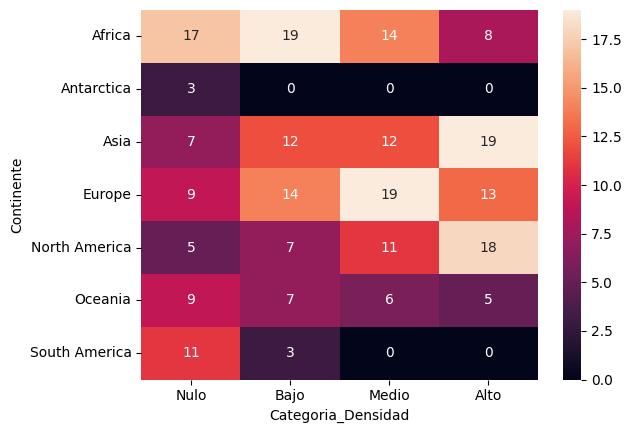

In [ ]:
df_heatmap = df_pais.pivot_table(index='Continente', columns='Categoria_Densidad', values='Pais', aggfunc='count')
sns.heatmap(df_heatmap,annot=True)
plt.show()

(array([2., 2., 1., 0., 0., 0., 1., 0., 0., 1.]),
 array([1.18781428e-02, 9.87552050e+01, 1.97498532e+02, 2.96241859e+02,
        3.94985186e+02, 4.93728513e+02, 5.92471839e+02, 6.91215166e+02,
        7.89958493e+02, 8.88701820e+02, 9.87445147e+02]),
 <BarContainer object of 10 artists>)

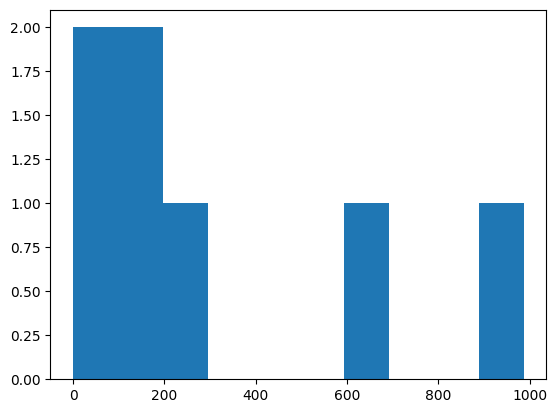

In [ ]:
plt.hist(df_continente['Densidad_Poblacional'])

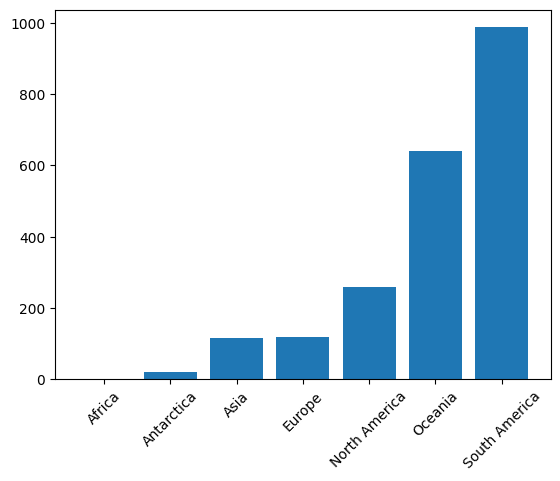

In [ ]:
plt.bar(df_continente['Continente'].sort_values(), df_continente['Densidad_Poblacional'].sort_values())
plt.xticks(rotation=45)

plt.show()

In [ ]:
df_continente

,Continente,Densidad_Poblacional,Pais,Idiomas,Area,Poblacion
0,Africa,114.8148,58,9,30318357.0000,1362092235
1,Antarctica,0.0119,5,3,14012111.0000,1430
2,Asia,987.4451,50,26,31253314.0000,4508832965
3,Europe,641.2750,55,36,23954459.4600,841383255
4,North America,258.1455,41,6,24244506.0000,590080423
5,Oceania,119.7767,27,6,8530072.2000,44435558
6,South America,20.6707,14,7,17833382.0000,430895697


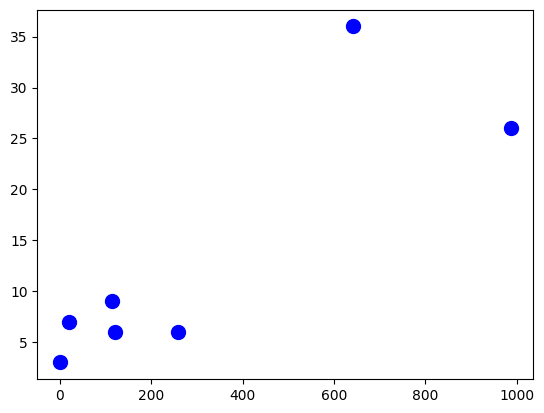

In [ ]:
x = df_continente['Densidad_Poblacional']
y = df_continente['Idiomas']
plt.scatter(x, y, c='blue', s=100) # c=color, s=tamaño